| ![EEW logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/eew.jpg?raw=true) | ![EDGI logo](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/edgi.png?raw=true) |
|---|---|

#### This Jupyter Notebook is licensed under GPL 3.0. Please visit our Github organization for more information:  https://github.com/edgi-govdata-archiving/
#### The notebook was collaboratively authored by the Environmental Data & Governance Initiative (EDGI) following our authorship protocol: https://docs.google.com/document/d/1CtDN5ZZ4Zv70fHiBTmWkDJ9mswEipX6eCYrwicP66Xw/
#### For more information about this project, visit https://www.environmentalenforcementwatch.org/

## How to Run this Notebook
* If you click on a gray **code** cell, a little “play button” arrow appears on the left. If you click the play button, it will run the code in that cell (“**running** a cell”). The button will animate. When the animation stops, the cell has finished running.
![Where to click to run the cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/pressplay.JPG?raw=true)
* You may get a warning that the notebook was not authored by Google. We know, we authored them! It’s okay. Click “Run Anyway” to continue. 
![Error Message](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/warning-message.JPG?raw=true)
* Run all of the cells in a Notebook to make a complete report. Please feel free to look at and **learn about each result as you create it**!

---

# Who's responsible for greenhouse gas emissions?
Under the US Environmental Protection Agency's Greenhouse Gas Reporting Program (GHGRP), a variety of emitters are required to count and report their emissions anually. 

Conceptually this is similar to reporting pollutant discharages under the Clean Water Act's National Pollutant Discharge Elimination System (NPDES), but whereas NPDES has legal teeth - facilities are permitted to release only so much of a pollutant into the water - there is no such equivalent legislation for GHGs.

Facilities reporting GHGs are also required to report information about ownership - the share a parent company has in the facility. 

Through this information we can determine not just which specific facilities reported the most GHGs every year, but which companies can be said to be the most responible in terms of their ownership of these facilities.

The GHGRP does not attempt to account for all of the US's GHG emissions; the GHG Inventory does that: https://www.epa.gov/ghgemissions/inventory-us-greenhouse-gas-emissions-and-sinks But GHGRP focuses on industrial direct emitters and some suppliers above certain thresholds. As EPA notes, "The GHGRP does not represent total U.S. GHG emissions, but provides facility level data for large sources of direct emissions, thus representing the majority of U.S. GHG emissions. The GHGRP data collected from direct emitters represent about half of all U.S. emissions." Including estimates from suppliers of fossil fuels, the GHGRP dataset can account for up to 90% of all US emissions: https://www.epa.gov/ghgreporting/learn-about-greenhouse-gas-reporting-program-ghgrp

This notebook uses this data source to estimate GHG emissions by parent company. For further information about how the GHGRP works, please see here: https://docs.google.com/presentation/d/1EVtWOFDEeaqZhg1FTf0IsEL3M736hITP5G76q9l6bP0/edit#slide=id.g884825dbd0_0_6 or here: https://www.epa.gov/ghgreporting

# Setup
Here we load some helper code to get us going.

In [ ]:
# Import code libraries
import pandas as pd
import requests, zipfile, io
!pip install pyxlsb
import pyxlsb

import warnings
warnings.filterwarnings('ignore')

# Set up some default parameters for graphing
import matplotlib.pyplot as plt
from matplotlib import cycler
colour = "#00C2AB" # The default colour for the barcharts
colors = cycler('color', ['#4FBBA9', '#E56D13', '#D43A69','#25539f', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)
plt.rc('legend', fancybox = True, framealpha=1, shadow=True, borderpad=1)

print("Done!")

Done!


# Getting emissions data

We will "download" EPA's emissions data into our notebook here.

In [ ]:
url = "https://www.epa.gov/system/files/other-files/2021-10/2020_data_summary_spreadsheets.zip"
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("/content")

# We will load in the sheets in the unzipped XLSX file that contain various kinds of direct emissions, from individual facilities and sectors/activities
ghg_fac = pd.read_excel("/content/ghgp_data_2020.xlsx",
  skiprows = 1, # skip the first two rows, which are irrelevant
  header = 2, # the third row represents the header
  sheet_name = ["Direct Emitters", "Onshore Oil & Gas Prod.", "Gathering & Boosting", 
    "Transmission Pipelines", "LDC - Direct Emissions", "SF6 from Elec. Equip.", "Suppliers"]) 

print("Data loaded!")

Data loaded!


## Summarize emissions data by facility

The emissions data are presented in several different sections of EPA's spreadsheet, so here we compile them all together. 

Emissions are measured in metric tons of CO2 equivalent, or tCO2e (see: https://www.theguardian.com/environment/2011/apr/27/co2e-global-warming-potential)

As output, we'll show the top 20 emitting facilities nationwide.

In [ ]:
# First, handle suppliers separately
# Treat NaNs as zeros (not reported, maybe not emitted)
# Skip "confidential" values
ghg_fac["Suppliers"]["Total"] = pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Coal-based liquid fuel production"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Petroleum Products Produced"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Petroleum Products Imported"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Petroleum Products Exported"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Natural Gas Supply"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with Natural Gas Liquids Supply"], errors='coerce').fillna(0) + \
  pd.to_numeric(ghg_fac["Suppliers"]["GHG Quantity Associated with CO2 Supply "], errors='coerce').fillna(0)

emissions_field_names = {
    "Direct Emitters": "Total reported direct emissions",
    "Onshore Oil & Gas Prod.": "Total reported emissions from Onshore Oil & Gas Production ",
    "Gathering & Boosting": "Total reported emissions from Gathering & Boosting",
    "Transmission Pipelines": "Total reported direct emissions from Transmission Pipelines",
    "LDC - Direct Emissions": "Total reported direct emissions from Local Distribution Companies",
    "SF6 from Elec. Equip.": "Total reported direct emissions from Electrical Equipment Use",
    "Suppliers": "Total"
}

fac_data = pd.DataFrame([], columns=["Facility", "Name", "Emissions (tCO2e)"]) # Create a new DataFrame to store emissions data compiled from across sectors

#Compile emissions data across different sectors.
# !!! Need to keep direct emitters separate from suppliers, pipelines, etc. https://ccdsupport.com/confluence/pages/viewpage.action?pageId=98598976
for key in emissions_field_names.keys():
  dump = ghg_fac[key]
  dump = dump[["Facility Id", "Facility Name", emissions_field_names[key]]]
  dump = dump.rename(columns={"Facility Id": "Facility", "Facility Name": "Name", emissions_field_names[key]:"Emissions (tCO2e)"})
  dump["Emissions (tCO2e)"] = pd.to_numeric(dump["Emissions (tCO2e)"])
  fac_data = fac_data.append(dump)

#Roll up duplicate facility IDs (facilities with e.g. both direct emissions and onshore oil...)
fac = fac_data.groupby(by=["Facility", "Name"]).sum() #For presentation purposes, we'll add in the facility name
fac_data = fac_data.groupby(by=["Facility"]).sum() # For analysis purposes, we'll leave the name off...it'll get added back in when we add it to the parent company table

fac.nlargest(20,"Emissions (tCO2e)").style.format({"Emissions (tCO2e)": '{:,.0f}'})

,,Emissions (tCO2e)
Facility,Name,
1007458,MOTIVA ENTERPRISES LLC,"89,601,267"
1003043,Garyville Refinery,"88,187,629"
1007542,EXXONMOBIL Bt Site,"87,378,535"
1007643,EXXONMOBIL BATON ROUGE REFINERY AND CHEMICAL PLANT,"75,108,887"
1005585,Galveston Bay Refinery,"72,793,801"
1010448,Enterprise Products Operating LLC,"66,679,801"
1007339,BP Whiting Business Unit,"62,343,671"
1010568,Valero Marketing and Supply Company,"61,214,779"
1007959,Exxonmobil Beaumont Refinery,"49,867,266"


Export this processed data, if you like (optional), by running the cell below.


In [ ]:
if ( fac is not None):
    fac.to_csv( 'ghgdata.csv' )
    print("Exported! Check the 'Files' folder in Colab to download it.")

Exported! Check the 'Files' folder in Colab to download it.


# Add parent company data

Now we'll get EPA's information on who owns these facilities.

In [ ]:
url = "https://www.epa.gov/system/files/other-files/2021-10/ghgp_data_parent_company_10_2021.xlsb"
parents = pd.read_excel(url, engine='pyxlsb', sheet_name="2020", nrows=9144) # 9144 non-header rows in this file as of Nov 2021.
parents["PARENT COMPANY NAME"] = parents["PARENT COMPANY NAME"].str.upper() # Standardize company names to uppercase - sometimes EPA allows company names to be reported in upper and lower case, which intereferes with our ability to aggregate them
parents

,GHGRP FACILITY ID,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE
0,1000001,1.100005e+11,2020,PSE Ferndale Generating Station,5105 LAKE TERRELL ROAD,FERNDALE,WA,98248,WHATCOM COUNTY,PUGET HOLDINGS LLC,PO Box 97034,Bellevue,WA,98009,100.0,221112
1,1000002,1.100412e+11,2020,Ardagh Glass Inc. (Dunkirk),524 E. CENTER STREET,DUNKIRK,IN,47336,JAY COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213
2,1000003,1.100015e+11,2020,Ardagh Glass Inc. (Henderson),620 Facet Road,Henderson,NC,27537,VANCE COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213
3,1000005,1.100005e+11,2020,Ardagh Glass Inc. (Madera),24441 AVENUE 12 & ROAD 24 1/2,MADERA,CA,93637,MADERA COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213
4,1000007,1.100070e+11,2020,AMERICAN GYPSUM - BERNALILLO (WALLBOARD) PLANT,1000 N HILL RD,BERNALILLO,NM,87004,SANDOVAL COUNTY,EAGLE MATERIALS INC,5960 Berkshire Lane Suite 800,Dallas,TX,75225,100.0,327420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9139,1014033,NaN,2020,AW PRODUCT SALES AND MARKETING INC,"204 E. 2nd Avenue, Unit #343",San Mateo,CA,94401,NaN,AW DISTRIBUTING INC,"204 E. 2nd Avenue, Unit #343",San Mateo,CA,94401,100.0,522293
9140,1014041,NaN,2020,"Bluon, Inc.",18 Bunsen,Irvine,CA,92618,NaN,BLUON INC,18 Bunsen,Irvine,CA,92618,100.0,424690
9141,1014043,NaN,2020,RAMJ Enterprises Inc,4912 W KNOX ST STE 100,Tampa,FL,33634,NaN,RAMJ ENTERPRISES INC,4912 W KNOX ST,Tampa,FL,33634,100.0,425120
9142,1014044,1.100626e+11,2020,Wilhelmsen Ships Service Inc,9400 New Century Dr,Pasadena,TX,77507,HARRIS COUNTY,WILHELMSEN SHIPS SERVICE,9400 New Century Dr.,Pasadena,TX,77507,100.0,484220


# Pair parents with facilities

In [ ]:
# Join tables between Facility and GHGRP FACILITY ID
# Basically we are saying, for each facility, and for each parent/stake, what emissions?
# First we'll join in all emissions, then later we'll account for specific percent ownership and reduce emissions according to these stakes.
join = parents.set_index('GHGRP FACILITY ID').join(fac_data)
join

,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE,Emissions (tCO2e)
1000001,1.100005e+11,2020,PSE Ferndale Generating Station,5105 LAKE TERRELL ROAD,FERNDALE,WA,98248,WHATCOM COUNTY,PUGET HOLDINGS LLC,PO Box 97034,Bellevue,WA,98009,100.0,221112,509154.612
1000002,1.100412e+11,2020,Ardagh Glass Inc. (Dunkirk),524 E. CENTER STREET,DUNKIRK,IN,47336,JAY COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213,113519.804
1000003,1.100015e+11,2020,Ardagh Glass Inc. (Henderson),620 Facet Road,Henderson,NC,27537,VANCE COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213,81110.872
1000005,1.100005e+11,2020,Ardagh Glass Inc. (Madera),24441 AVENUE 12 & ROAD 24 1/2,MADERA,CA,93637,MADERA COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213,79854.076
1000007,1.100070e+11,2020,AMERICAN GYPSUM - BERNALILLO (WALLBOARD) PLANT,1000 N HILL RD,BERNALILLO,NM,87004,SANDOVAL COUNTY,EAGLE MATERIALS INC,5960 Berkshire Lane Suite 800,Dallas,TX,75225,100.0,327420,14084.496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014033,NaN,2020,AW PRODUCT SALES AND MARKETING INC,"204 E. 2nd Avenue, Unit #343",San Mateo,CA,94401,NaN,AW DISTRIBUTING INC,"204 E. 2nd Avenue, Unit #343",San Mateo,CA,94401,100.0,522293,0.000
1014041,NaN,2020,"Bluon, Inc.",18 Bunsen,Irvine,CA,92618,NaN,BLUON INC,18 Bunsen,Irvine,CA,92618,100.0,424690,0.000
1014043,NaN,2020,RAMJ Enterprises Inc,4912 W KNOX ST STE 100,Tampa,FL,33634,NaN,RAMJ ENTERPRISES INC,4912 W KNOX ST,Tampa,FL,33634,100.0,425120,0.000
1014044,1.100626e+11,2020,Wilhelmsen Ships Service Inc,9400 New Century Dr,Pasadena,TX,77507,HARRIS COUNTY,WILHELMSEN SHIPS SERVICE,9400 New Century Dr.,Pasadena,TX,77507,100.0,484220,0.000


Show and remove the facilities/parents have no reported emissions. 

We remove them because we don't want to end up having to convert their values to 0 and suggesting those facilities/companies have no actual emissions when they just have no reported emissions.

In [ ]:
nas = join.loc[join["Emissions (tCO2e)"].isna()]
join = join.drop(nas.index)
nas

,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE,Emissions (tCO2e)
1003698,1.100555e+11,2020,Salt Creek CO2 Supplier,NaN,Midwest,WY,82643,NIOBRARA COUNTY,DENBURY INC,5320 S Legacy Dr,Plano,TX,75024,23.0,211120,NaN
1003698,1.100555e+11,2020,Salt Creek CO2 Supplier,NaN,Midwest,WY,82643,NIOBRARA COUNTY,FDL OPERATING LLC,5221 N O'Connor Blvd #1100,Irving,TX,75039,77.0,211120,NaN
1004617,1.100555e+11,2020,Monell CO2 Supplier,NaN,Monell,WY,82901,SWEETWATER COUNTY,FDL OPERATING LLC,5221 N O'Connor Blvd #1100,Irving,TX,75039,100.0,211120,NaN
1009570,1.100555e+11,2020,Wasson San Andres,2611 State Hwy 214,Denver City,TX,79232,YOAKUM COUNTY,OCCIDENTAL PETROLEUM CORP,"5 Greenway Plaza, Suite 110",Houston,TX,77046,100.0,211120,NaN
1009630,1.100246e+11,2020,Brookhaven EOR Facility,1030 California Road,Brookhaven,MS,39601,LINCOLN COUNTY,DENBURY INC,"5851 Legacy Circle, Suite #1200",Plano,TX,75024,100.0,211120,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012881,1.100702e+11,2020,"PC Energy, LLC",93 SE 7th Ave,Ontario,OR,97914,MALHEUR COUNTY,CAMPO OIL CO INC,400 S Pennsylvania Ave,Fruitland,ID,83619,50.0,424720,NaN
1012922,1.100705e+11,2020,Apache Alpine High Pipeline,"17802 IH-10 West, STE300",San Antonio,TX,78257,BEXAR COUNTY,APACHE CORP,"17802 IH-10 West, STE 300",San Antonio,TX,78257,100.0,221210,NaN
1013090,1.100702e+11,2020,Indian Basin AGI,NaN,Lakewood,NM,88254,EDDY COUNTY,OCCIDENTAL PETROLEUM CORP,"5 Greenway Plaza, Suite 110",Houston,TX,77046,100.0,211120,NaN
1013103,1.100702e+11,2020,"Roadrunner Gas Transmission, LLC",100 West Fifth Street,Tulsa,OK,74103,TULSA COUNTY,ONEOK INC,"100 West Fifth Street, P.O. Box 871",Tulsa,OK,74103,100.0,486210,NaN


# Calculate parent responsibility based on percent ownership

Some companies have less than 100% ownership of a given facility - they share ownership with other entities. We divide a facility's emissions between all owners according to their percent share.

In [ ]:
# PARENT SHARE = for each facility, and for each owner, how many of that facility's emissions was that owner responsible for based on percent ownership.
join["PARENT EMISSIONS AMT"] = join['Emissions (tCO2e)'] * join["PARENT CO. PERCENT OWNERSHIP"] / 100 
join

,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE,Emissions (tCO2e),PARENT EMISSIONS AMT
1000001,1.100005e+11,2020,PSE Ferndale Generating Station,5105 LAKE TERRELL ROAD,FERNDALE,WA,98248,WHATCOM COUNTY,PUGET HOLDINGS LLC,PO Box 97034,Bellevue,WA,98009,100.0,221112,509154.612,509154.612
1000002,1.100412e+11,2020,Ardagh Glass Inc. (Dunkirk),524 E. CENTER STREET,DUNKIRK,IN,47336,JAY COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213,113519.804,113519.804
1000003,1.100015e+11,2020,Ardagh Glass Inc. (Henderson),620 Facet Road,Henderson,NC,27537,VANCE COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213,81110.872,81110.872
1000005,1.100005e+11,2020,Ardagh Glass Inc. (Madera),24441 AVENUE 12 & ROAD 24 1/2,MADERA,CA,93637,MADERA COUNTY,ARDAGH GLASS INC,1209 Orange Street,Wilmington,DE,19801,100.0,327213,79854.076,79854.076
1000007,1.100070e+11,2020,AMERICAN GYPSUM - BERNALILLO (WALLBOARD) PLANT,1000 N HILL RD,BERNALILLO,NM,87004,SANDOVAL COUNTY,EAGLE MATERIALS INC,5960 Berkshire Lane Suite 800,Dallas,TX,75225,100.0,327420,14084.496,14084.496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014033,NaN,2020,AW PRODUCT SALES AND MARKETING INC,"204 E. 2nd Avenue, Unit #343",San Mateo,CA,94401,NaN,AW DISTRIBUTING INC,"204 E. 2nd Avenue, Unit #343",San Mateo,CA,94401,100.0,522293,0.000,0.000
1014041,NaN,2020,"Bluon, Inc.",18 Bunsen,Irvine,CA,92618,NaN,BLUON INC,18 Bunsen,Irvine,CA,92618,100.0,424690,0.000,0.000
1014043,NaN,2020,RAMJ Enterprises Inc,4912 W KNOX ST STE 100,Tampa,FL,33634,NaN,RAMJ ENTERPRISES INC,4912 W KNOX ST,Tampa,FL,33634,100.0,425120,0.000,0.000
1014044,1.100626e+11,2020,Wilhelmsen Ships Service Inc,9400 New Century Dr,Pasadena,TX,77507,HARRIS COUNTY,WILHELMSEN SHIPS SERVICE,9400 New Century Dr.,Pasadena,TX,77507,100.0,484220,0.000,0.000


Optional view specifically on facilities with multiple owners

In [ ]:
join.loc[join["PARENT CO. PERCENT OWNERSHIP"]<100]

,FRS ID (FACILITY),REPORTING YEAR,FACILITY NAME,FACILITY ADDRESS,FACILITY CITY,FACILITY STATE,FACILITY ZIP,FACILITY COUNTY,PARENT COMPANY NAME,PARENT CO. STREET ADDRESS,PARENT CO. CITY,PARENT CO. STATE,PARENT CO. ZIP,PARENT CO. PERCENT OWNERSHIP,FACILITY NAICS CODE,Emissions (tCO2e),PARENT EMISSIONS AMT
1000035,1.100376e+11,2020,THE ANDERSONS MARATHON HOLDINGS LLC,5728 E SEBRING WARNER RD,GREENVILLE,OH,45331,DARKE COUNTY,THE ANDERSONS INC,PO Box 119,Maumee,OH,43537,50.0000,325193,164947.828,82473.914000
1000035,1.100376e+11,2020,THE ANDERSONS MARATHON HOLDINGS LLC,5728 E SEBRING WARNER RD,GREENVILLE,OH,45331,DARKE COUNTY,MARATHON PETROLEUM CORP,539 South Main Street,Findlay,OH,45840,25.0000,325193,164947.828,41236.957000
1000035,1.100376e+11,2020,THE ANDERSONS MARATHON HOLDINGS LLC,5728 E SEBRING WARNER RD,GREENVILLE,OH,45331,DARKE COUNTY,MARATHON PETROLEUM CORP,539 South Main Street,Findlay,OH,45840,25.0000,325193,164947.828,41236.957000
1000047,1.100099e+11,2020,PENOBSCOT ENERGY RECOVERY CO.,29 INDUSTRIAL WAY,ORRINGTON,ME,4474,PENOBSCOT COUNTY,USA ENERGY GROUP LLC,"100 N Sixth Avenue, Ste 300A",Minneapolis,MN,55403,69.3100,562213,38877.338,26945.882968
1000047,1.100099e+11,2020,PENOBSCOT ENERGY RECOVERY CO.,29 INDUSTRIAL WAY,ORRINGTON,ME,4474,PENOBSCOT COUNTY,TOWN OF ORLAND,25 School House Road,Orland,ME,4472,0.0795,562213,38877.338,30.907484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1013838,NaN,2020,SGP Sierrita Compressor Station,11011 West Ajo Highway,Tucson,AZ,85735,NaN,MGI ENTERPRISES US LLC,Centro Administrativo de Petroleos Mexicanos P...,Colonia Petroleos,AZ,11300,35.0000,486210,35064.868,12272.703800
1013838,NaN,2020,SGP Sierrita Compressor Station,11011 West Ajo Highway,Tucson,AZ,85735,NaN,KINDER MORGAN INC,1001 Louisiana St. Suite 1000,Houston,TX,77002,35.0000,486210,35064.868,12272.703800
1013950,1.100709e+11,2020,Combs Investment Property LP,"2777 Allen Parkway, Suite 1185",Houston,TX,77019,HARRIS COUNTY,"CLAUSA-CC, LLC","2777 Allen Pkwy, Suite 1185",Houston,TX,77019,1.0000,423740,0.000,0.000000
1013950,1.100709e+11,2020,Combs Investment Property LP,"2777 Allen Parkway, Suite 1185",Houston,TX,77019,HARRIS COUNTY,"ATOMIC CAPITAL REFRIGERANTS, LLC","2777 Allen Pkwy, Suite 1185",Houston,TX,77019,99.0000,423740,0.000,0.000000


# Summarize by parent company
A major assumption here is that parent company names are standardized in EPA's database.

We show the top ten parent companies in terms of emissions.

Re-run the cell below and change `summary.nlargest(10, "PARENT EMISSIONS AMT")` to some other number than 10 to see more of the ranking.

In [ ]:
summary = join.groupby("PARENT COMPANY NAME")[["PARENT EMISSIONS AMT"]].sum()
summary.nlargest(10, "PARENT EMISSIONS AMT").style.format({"PARENT EMISSIONS AMT": '{:,.0f}'})

,PARENT EMISSIONS AMT
PARENT COMPANY NAME,
MARATHON PETROLEUM CORP,"428,917,438"
PHILLIPS 66,"348,755,407"
EXXON MOBIL CORP,"323,088,959"
VALERO ENERGY CORP,"320,383,402"
ENTERPRISE PRODUCTS PARTNERS LP,"178,888,036"
SHELL PETROLEUM INC,"165,165,588"
CHEVRON CORP,"155,252,935"
BP AMERICA INC,"149,695,636"
THE SOUTHERN CO,"119,179,346"


What share of all US emissions covered under EPA's GHGRP do these 10 corporations account for? (See similar measurements done for the entire world and for several decades: https://b8f65cb373b1b7b15feb-c70d8ead6ced550b4d987d7c03fcdd1d.ssl.cf3.rackcdn.com/cms/reports/documents/000/002/327/original/Carbon-Majors-Report-2017.pdf?1499691240)

In [ ]:
#int(fac_data.sum()) #6,648,566,817 - emissions total from the XLSX file
#int(summary["PARENT EMISSIONS AMT"].sum()) 6,610,541,381 - emissions total from after joining with parent companies.
# There is a discrepancy of about 38,000,000 tons. It is likely that there are some facilities that reported emissions to the GHGRP that could not be matched with a parent company in EPA's database.
(summary.nlargest(10, "PARENT EMISSIONS AMT").sum() / summary["PARENT EMISSIONS AMT"].sum()) * 100

PARENT EMISSIONS AMT    34.873409
dtype: float64

How many companies account for ~50% of US emissions reported under GHGRP? By adjusting the number in `summary.nlargest(#)` we can see that just the 23 largest companies account for 50% of reported GHG emissions.

In [ ]:
(summary.nlargest(23, "PARENT EMISSIONS AMT").sum() / summary["PARENT EMISSIONS AMT"].sum()) * 100

PARENT EMISSIONS AMT    50.572783
dtype: float64

# Summarize by parent company plus geography

Illustrate the top polluting companies based on owned facilities within a specific state

In [ ]:
# First, choose which state
states = list(join['FACILITY STATE'].unique())
states.sort()

import ipywidgets as widgets
state_selection = widgets.Dropdown(
    options=states,
    description='Select a state:'
)
state_selection

Dropdown(description='Select a state:', options=('AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', '…

Next, we'll show the top ten parent companies in terms of emissions in this state.

Re-run the cell above to select a different geography and then run this one again to see the new results. You can also change `geo_summary.nlargest(10, "PARENT EMISSIONS AMT")` to some other number than 10 to see more of the ranking.

In [ ]:
# Filter the data to the selected state
geo_join = join.loc[join['FACILITY STATE'] == state_selection.value]
geo_summary = geo_join.groupby("PARENT COMPANY NAME")[["PARENT EMISSIONS AMT"]].sum()
geo_summary.nlargest(10, "PARENT EMISSIONS AMT").style.format({"PARENT EMISSIONS AMT": '{:,.0f}'})

,PARENT EMISSIONS AMT
PARENT COMPANY NAME,
BP AMERICA INC,"31,445,899"
SHELL PETROLEUM INC,"17,773,162"
MARATHON PETROLEUM CORP,"13,666,384"
PHILLIPS 66,"13,214,878"
PUGET HOLDINGS LLC,"7,650,987"
MDU RESOURCES GROUP INC,"7,402,714"
PAR PACIFIC HOLDINGS INC,"6,229,901"
TRANSALTA USA INC,"5,844,587"
PETROGAS WEST LLC,"2,988,204"


# Analyze

In what follows, we'll look at how specific kinds of parent companies/owners stack up in terms of emissions nationwide. To focus on the specific geography you selected above, just replace `summary.query` with `geo_summary.query`

How are universities implicated? Let's look at the top 20. Again, to see more of the ranking change ...`.nlargest(20, 'PARENT EMISSIONS AMT')` to some other number than 20. You can also focus on universities within your selected geography by change `summary.query` to `geo_summary.query`

In [ ]:
df = summary.query("index.str.lower().str.contains('university')",engine='python').nlargest(20, 'PARENT EMISSIONS AMT')
df.style.format({"PARENT EMISSIONS AMT": '{:,.0f}'})

,PARENT EMISSIONS AMT
PARENT COMPANY NAME,
MICHIGAN STATE UNIVERSITY,"337,811"
UNIVERSITY OF TEXAS SYSTEM,"323,375"
UNIVERSITY OF ILLINOIS,"309,406"
THE REGENTS OF THE UNIVERSITY OF MICHIGAN,"245,596"
IOWA STATE UNIVERSITY OF SCIENCE & TECHNOLOGY,"203,541"
THE PENNSYLVANIA STATE UNIVERSITY,"154,219"
THE UNIVERSITY OF IOWA,"153,483"
CORNELL UNIVERSITY,"152,368"
UNIVERSITY OF CINCINNATI,"147,967"


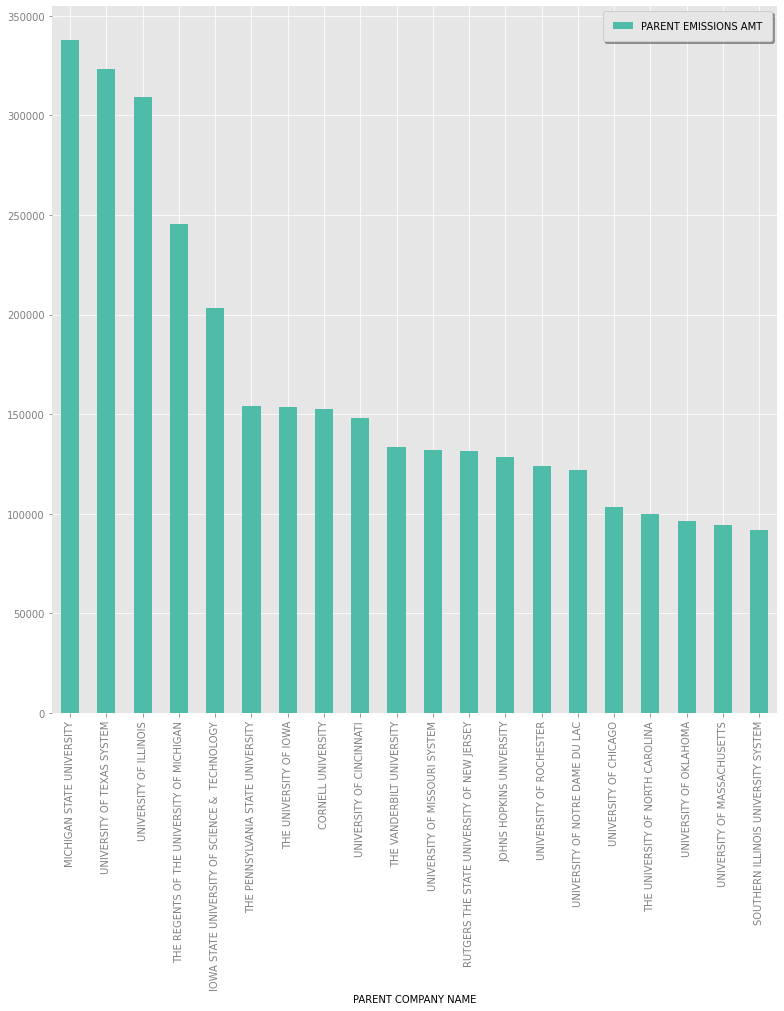

In [ ]:
df.plot(kind='bar', figsize=(13,13))

Municipalities?

In [ ]:
df = summary.query("index.str.lower().str.contains('city of')",engine='python').nlargest(20, 'PARENT EMISSIONS AMT')
df.style.format({"PARENT EMISSIONS AMT": '{:,.0f}'})

,PARENT EMISSIONS AMT
PARENT COMPANY NAME,
CITY OF MEMPHIS,"4,323,675"
CITY OF LOS ANGELES,"2,826,566"
CITY OF GAINESVILLE,"1,924,160"
CITY OF LAKELAND,"1,281,472"
CITY OF TALLAHASSEE,"1,229,470"
CITY OF RICHMOND,"1,197,058"
CITY OF KINGS MOUNTAIN,"1,104,326"
CITY OF SPRINGFIELD,"958,142"
CITY OF FREMONT,"604,576"


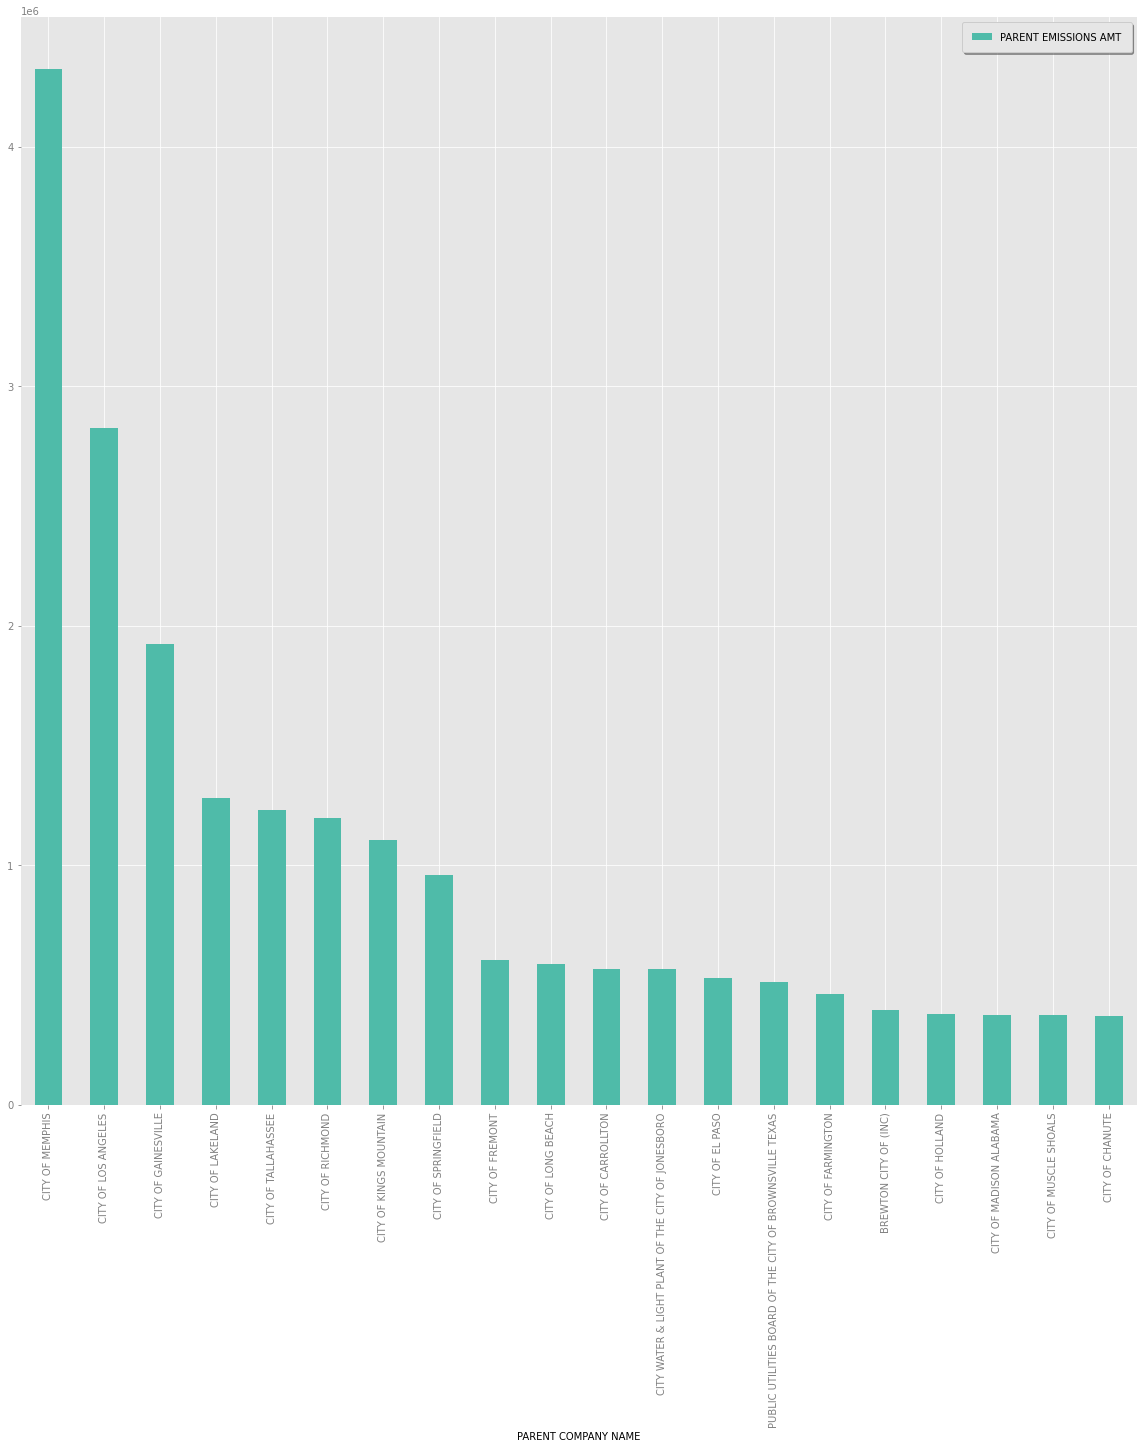

In [ ]:
df.plot(kind='bar', figsize=(20,20))

Something else?
Just change the query to see the results for yourself!

For instance, changing `contains('your query here')` to `contains('exxon')` would show us results for Exxon Mobil-related emissions. Be sure to uncapitalize everything.

In [ ]:
summary.query("index.str.lower().str.contains('your query here')",engine='python').nlargest(10, 'PARENT EMISSIONS AMT').style.format({"PARENT EMISSIONS AMT": '{:,.0f}'})